# __Ship satellite images classifier__

## Importazione delle principali librerie

In [1]:
import warnings

# Ignora il warning di sklearn riguardante i nomi delle feature durante la PCA
warnings.filterwarnings("ignore", message="X does not have valid feature names, but PCA was fitted with feature names", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

from skimage import color

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Definizione di costanti

In [4]:
COLOR_IMAGE_SIZE = (3, 80, 80)
IMAGE_SIZE = (80, 80)

ORIGINAL_DATASET_PATH = 'drive/MyDrive/ML/projFinale/shipsnet.json'
FINAL_DATASET_PATH = 'drive/MyDrive/ML/projFinale/data_gray.csv'
NN_WEIGHTS_PATH = "drive/MyDrive/ML/projFinale/ship_nn_weights.h5"
NN_CONFIG_PATH = "drive/MyDrive/ML/projFinale/ship_nn_config.json"
SVM_MODEL_DUMP_PATH = "drive/MyDrive/ML/projFinale/svmAddestratoSuTuttoDataset.pkl"

RANDOM_STATE = 57
(TRAINING_SET_SIZE, VALIDATION_SET_SIZE, TEST_SET_SIZE) = (0.7, 0.2, 0.1)

EPSILON = 1e-6

In [5]:
assert abs(TRAINING_SET_SIZE + VALIDATION_SET_SIZE + TEST_SET_SIZE - 1) < EPSILON, "Invalid split sizes"

__Random seed__ per la riproducibilità degli esperimenti:

In [6]:
np.random.seed(RANDOM_STATE)

## Importazione del dataset

Il dataset è una raccolta di __immagini satelittari__ *RGB* di dimensioni $3 \times 80 \times 80$, etichettate nella seguente maniera:
 - _1_: L'immagine contiene una __nave completa__;
 - _0_: L'immagine non contiene una nave (o contiene soltanto una parte di una nave);

In [7]:
with open(ORIGINAL_DATASET_PATH) as f:
    dataset = json.load(f)

dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [8]:
df = pd.DataFrame(np.array(dataset['data'], dtype=np.uint8))
df['labels'] = dataset['labels']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19191,19192,19193,19194,19195,19196,19197,19198,19199,labels
0,82,89,91,87,89,87,86,86,86,86,...,87,87,85,84,85,86,86,88,89,1
1,76,75,67,62,68,72,73,73,68,69,...,53,51,54,52,54,56,54,57,58,1
2,125,127,129,130,126,125,129,133,132,130,...,116,122,118,116,118,117,111,109,115,1
3,102,99,113,106,96,102,105,105,103,106,...,62,68,73,80,93,89,94,95,77,1
4,78,76,74,78,79,79,79,82,86,85,...,86,86,87,84,84,85,85,86,83,1


Dimensioni del dataset:

In [9]:
df.shape

(4000, 19201)

Tipi delle features:

In [10]:
df.dtypes

0         uint8
1         uint8
2         uint8
3         uint8
4         uint8
          ...  
19196     uint8
19197     uint8
19198     uint8
19199     uint8
labels    int64
Length: 19201, dtype: object

## Pre-processamento del dataset

 Visualizzazione di alcune immagini casuali del dataset originale:

In [11]:
n_images_to_show = 10
n_images_per_row = 5

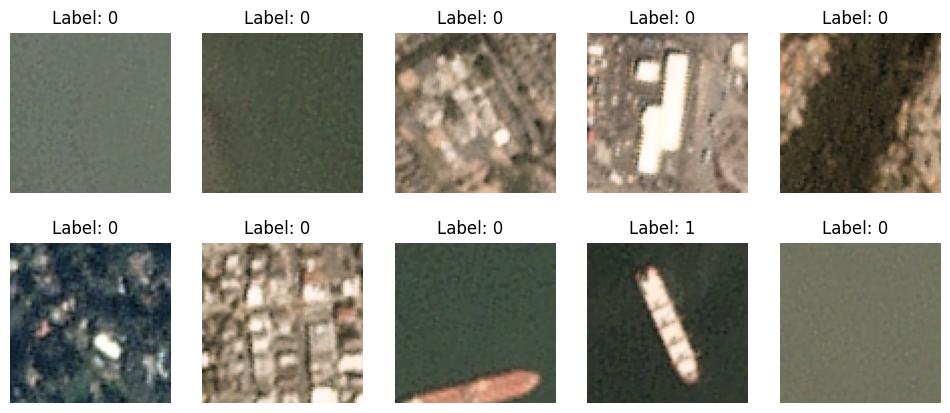

In [12]:
random_indexes = df.sample(n=n_images_to_show, random_state=RANDOM_STATE).index

images = [np.array(df.drop("labels", axis=1).iloc[i]).reshape(COLOR_IMAGE_SIZE).transpose(1, 2, 0) for i in random_indexes]
image_labels = df["labels"].iloc[random_indexes]

fig, ax = plt.subplots(n_images_to_show // n_images_per_row, n_images_per_row, figsize=(12, 5))

for i in range(n_images_to_show):
    ax[i // n_images_per_row, i % n_images_per_row].imshow(images[i])
    ax[i // n_images_per_row, i % n_images_per_row].text(37, -5, f"Label: {image_labels.iloc[i]}", size=12, ha="center")
    ax[i // n_images_per_row, i % n_images_per_row].axis('off')

plt.show()

### Trasformazione delle immagini in scala di grigi

Al fine di ridurne la dimensionalità, trasformiamo le immagini dal formato *RGB* al formato in *scala di grigi*, generando un nuovo dataset che utilizzeremo per addestrare i modelli.


In [13]:
data = np.array(dataset['data']).astype('uint8').reshape(-1, 3, 80, 80).transpose([0, 2, 3, 1]) #senza labels
print("Original dataset dimension: ", data.shape) #(4000, 80, 80, 3)

data_gray = np.array([color.rgb2gray(i) for i in data])
print("Gray-scaled dataset dimension: ", data_gray.shape) #(4000, 80, 80)

reshaped = data_gray.reshape(4000, 80*80)
print("Gray-scaled dataset dimension after rescaling: ", reshaped.shape) #(4000, 6400)

Original dataset dimension:  (4000, 80, 80, 3)
Gray-scaled dataset dimension:  (4000, 80, 80)
Gray-scaled dataset dimension after rescaling:  (4000, 6400)


Normalizzazione del nuovo dataset:

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(reshaped)

df = pd.DataFrame(scaled_data)

df["labels"] = dataset["labels"]
print("Normalized dataset dimension: ", df.shape) # 4000 x 6400

Normalized dataset dimension:  (4000, 6401)


Salvataggio del nuovo dataset in scala di grigi:

In [15]:
df.to_csv(FINAL_DATASET_PATH, index=False) # 4000 rows × 6401 columns, index=False sennò aggiunge una colonna in più

## Esplorazione del dataset

Importazione del dataset modificato:

In [16]:
dataset = pd.read_csv(FINAL_DATASET_PATH)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,6391,6392,6393,6394,6395,6396,6397,6398,6399,labels
0,-0.285437,-0.133429,-0.077142,-0.151093,-0.146871,-0.183299,-0.208957,-0.210868,-0.184394,-0.196788,...,-0.079107,-0.078704,-0.101311,-0.132484,-0.127265,-0.109197,-0.110486,-0.077432,-0.069558,1
1,-0.497033,-0.522849,-0.740923,-0.862685,-0.727362,-0.598122,-0.548538,-0.574434,-0.703203,-0.687444,...,-0.991468,-1.055051,-0.917155,-0.983874,-0.954296,-0.880394,-0.934622,-0.877058,-0.859065,1
2,0.849939,0.912636,0.970541,0.997052,0.897512,0.857427,0.965739,1.079913,1.059202,1.000223,...,0.827295,0.961522,0.900485,0.889425,0.961559,0.920461,0.802663,0.756099,0.876710,1
3,0.060611,-0.035531,0.264944,0.109182,-0.111732,0.043158,0.104698,0.083268,0.037028,0.100403,...,-0.697393,-0.563173,-0.373378,-0.155863,0.195845,0.073257,0.147910,0.166295,-0.345829,1
4,-0.567778,-0.601739,-0.658463,-0.534879,-0.514355,-0.535806,-0.554764,-0.413507,-0.275015,-0.317747,...,-0.064189,-0.063787,0.010552,-0.073231,-0.100727,-0.096205,-0.042403,-0.011093,-0.096740,1


Dimensione del dataset:

In [17]:
dataset.shape

(4000, 6401)

 Visualizzazione di alcune immagini casuali del dataset modificato:

In [18]:
n_image_to_show = 10
n_image_per_row = 5

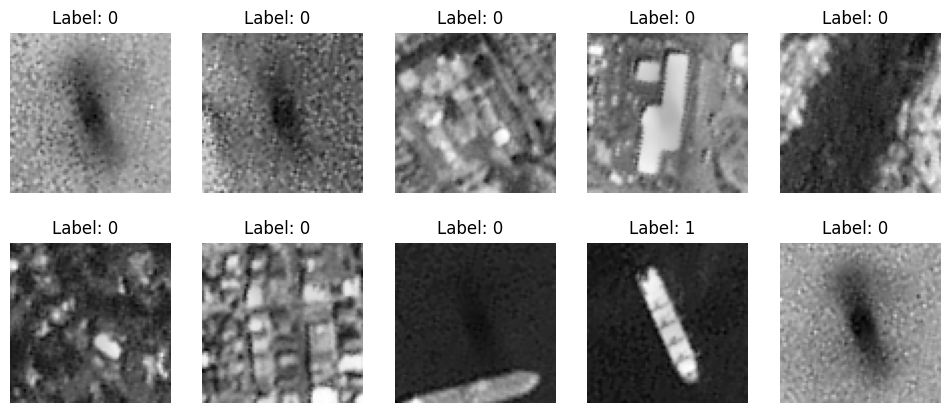

In [19]:
import matplotlib.pyplot as plt

image_bytes = dataset.drop(["labels"], axis=1).iloc[random_indexes]
image_bytes = [image_bytes.iloc[i].values[:] for i in range(n_image_to_show)]
images_label = dataset["labels"].iloc[random_indexes]
images = [image.reshape(IMAGE_SIZE) for image in image_bytes]
fig, ax = plt.subplots(n_image_to_show // n_image_per_row, n_image_per_row, figsize=(12, 5))

for i in range(n_image_to_show // n_image_per_row * n_image_per_row):
    ax[i // n_image_per_row, i % n_image_per_row].imshow(images[i], cmap='gray')
    ax[i // n_image_per_row, i % n_image_per_row].text(37, -5, f"Label: {images_label.iloc[i]}", size=12, ha="center")
    ax[i // n_image_per_row, i % n_image_per_row].axis('off')

plt.show()

Tipi delle features:

In [20]:
dataset.dtypes

0         float64
1         float64
2         float64
3         float64
4         float64
           ...   
6396      float64
6397      float64
6398      float64
6399      float64
labels      int64
Length: 6401, dtype: object

### Correlazione delle features

__Matrici di correlazione__ per sottoinsiemi disgiunti del dataset.

Primi 100 elementi:

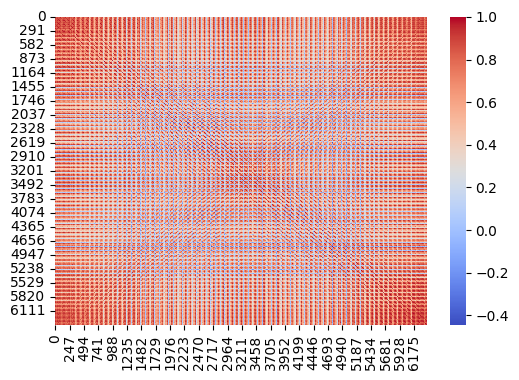

(6400, 6400)

In [21]:
correlation_matrix = dataset.head(100).drop("labels", axis=1).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

correlation_matrix.shape

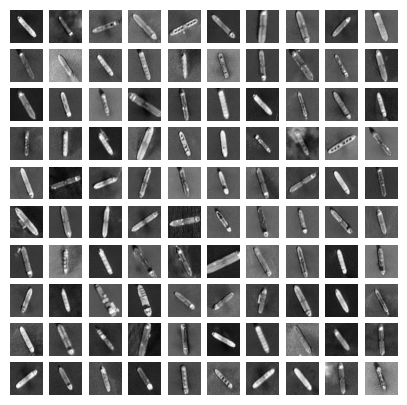

In [22]:
n_image_to_show = 100
n_image_per_row = 10

indexes=range(0, n_image_to_show)
image_bytes = dataset.drop(["labels"], axis=1).iloc[indexes]
image_bytes = [image_bytes.iloc[i].values[:] for i in range(n_image_to_show)]
images_label = dataset["labels"].iloc[indexes]
images = [image.reshape(IMAGE_SIZE) for image in image_bytes]
fig, ax = plt.subplots(n_image_to_show // n_image_per_row, n_image_per_row, figsize=(5, 5))

for i in range(n_image_to_show // n_image_per_row * n_image_per_row):
    ax[i // n_image_per_row, i % n_image_per_row].imshow(images[i], cmap='gray')
    ax[i // n_image_per_row, i % n_image_per_row].axis('off')

plt.show()

Dall'osservazione delle prime 100 immagini, osserviamo una certa uniformità del dato pittorico, e quindi è normale che le features (ovvero i pixel values) siano correlati tra di loro in questo sottoinsieme di dati.

100 elementi centrali:

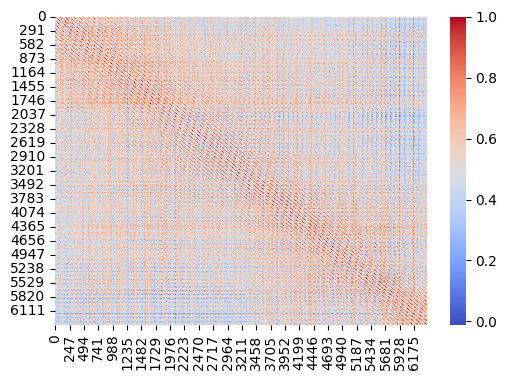

(6400, 6400)

In [23]:
correlation_matrix = dataset.iloc[len(dataset)//2 - 50:len(dataset)//2 + 50].drop("labels", axis=1).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

correlation_matrix.shape

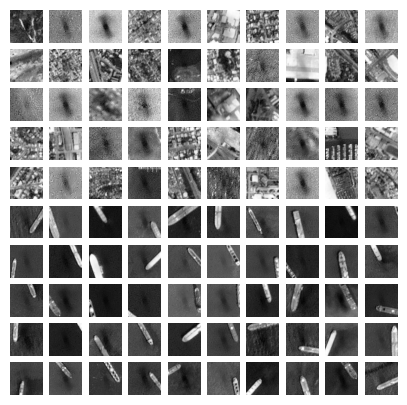

In [24]:
n_image_to_show = 100
n_image_per_row = 10
indexes = range(len(dataset)//2 - 50, len(dataset)//2 + 50)

image_bytes = dataset.drop(["labels"], axis=1).iloc[indexes]
image_bytes = [image_bytes.iloc[i].values[:] for i in range(n_image_to_show)]
images_label = dataset["labels"].iloc[indexes]
images = [image.reshape(IMAGE_SIZE) for image in image_bytes]
fig, ax = plt.subplots(n_image_to_show // n_image_per_row, n_image_per_row, figsize=(5, 5))

for i in range(n_image_to_show // n_image_per_row * n_image_per_row):
    ax[i // n_image_per_row, i % n_image_per_row].imshow(images[i], cmap='gray')
    ax[i // n_image_per_row, i % n_image_per_row].axis('off')

plt.show()

Qui le immagini risultano più variegate e quindi con una correlazione meno marcata.

100 immagini casuali:

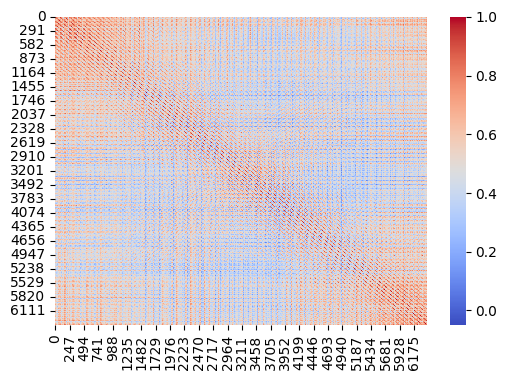

(6400, 6400)

In [29]:
random_indexes = dataset.sample(n=100, random_state=RANDOM_STATE).index

correlation_matrix = dataset.loc[random_indexes].drop("labels", axis=1).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

correlation_matrix.shape

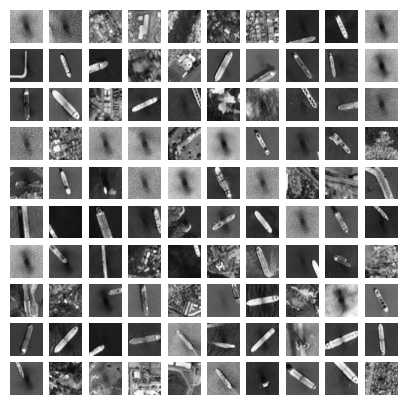

In [30]:
image_bytes = dataset.drop(["labels"], axis=1).iloc[random_indexes]
image_bytes = [image_bytes.iloc[i].values[:] for i in range(n_image_to_show)]
images_label = dataset["labels"].iloc[indexes]
images = [image.reshape(IMAGE_SIZE) for image in image_bytes]
fig, ax = plt.subplots(n_image_to_show // n_image_per_row, n_image_per_row, figsize=(5, 5))

for i in range(n_image_to_show // n_image_per_row * n_image_per_row):
    ax[i // n_image_per_row, i % n_image_per_row].imshow(images[i], cmap='gray')
    ax[i // n_image_per_row, i % n_image_per_row].axis('off')

plt.show()

Anche estraendo 100 immagini casuali resta un certo __grado di correlazione__ tra le features. Sarà necessario l'utilizzo di modelli che non risentano eccessivamente di questa caratteristica del __dataset__.

### Distribuzione delle classi:

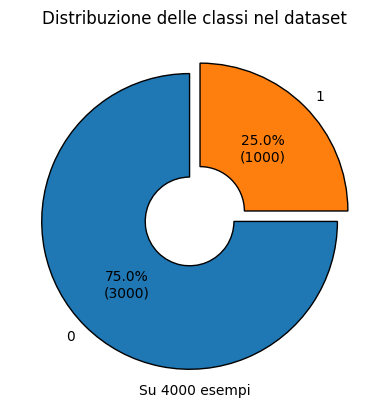

In [ ]:
target_features_number = dict(dataset.value_counts("labels"))

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
        autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(dataset))})",
        startangle=90,
        wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
        explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel dataset")
plt.text(0, -1.2, f"Su {len(dataset)} esempi", ha='center')
plt.show()

Le classi sono distribuite secondo un __rapporto 3 a 1__ per la __classe negativa__: potrebbe essere necessario un bilanciamento del __training set__.

### Suddivisione del dataset in __training set__ , __validation test__ e __test set__
Si opta per una divisione del tipo:
 - $70\%$ __training set__
 - $20\%$ __validation set__
 - $10\%$ __test set__

In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.drop("labels", axis=1), dataset["labels"], test_size=TEST_SET_SIZE, random_state=RANDOM_STATE)

In [ ]:
assert abs(X_test.shape[0] - dataset.shape[0] * TEST_SET_SIZE) <= 1, "Invalid test split size: " + str(X_test.shape[0]) + " instead of " + str(dataset.shape[0] * TEST_SET_SIZE)
assert X_train_val.shape[1] == IMAGE_SIZE[0] * IMAGE_SIZE[1], "Invalid X_train_val shape: " + str(X_train_val.shape)
assert X_test.shape[1] == IMAGE_SIZE[0] * IMAGE_SIZE[1], "Invalid X_test shape: " + str(X_test.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VALIDATION_SET_SIZE / (TRAINING_SET_SIZE + VALIDATION_SET_SIZE), random_state=RANDOM_STATE)

In [ ]:
assert abs(X_train.shape[0] - dataset.shape[0] * TRAINING_SET_SIZE) <= 1, "Invalid training split size: " + str(X_train.shape[0]) + " instead of " + str(dataset.shape[0] * TRAINING_SET_SIZE)
assert abs(X_val.shape[0] - dataset.shape[0] * VALIDATION_SET_SIZE) <= 1, "Invalid validation split size: " + str(X_val.shape[0]) + " instead of " + str(dataset.shape[0] * VALIDATION_SET_SIZE)

## Ricampionamento del __training set__

Per equilibrare le classi del __training set__, utilizziamo sia l'**oversampling** della classe meno rappresentata che che l'**undersampling** di quella più rappresentata.

Distribuzione iniziale delle classe del __training set__:

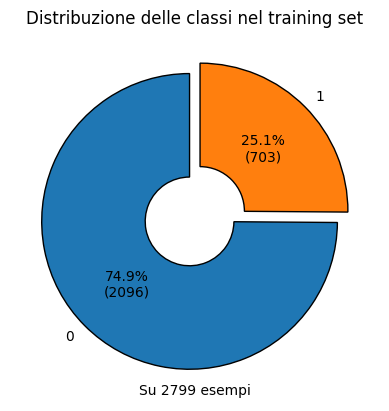

In [ ]:
target_features_number = dict(y_train.value_counts())

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
                autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(X_train))})",
                startangle=90,
                wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
                explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel training set")
plt.text(0, -1.2, f"Su {len(X_train)} esempi", ha='center')

plt.show()

In [ ]:
resized_X_train = X_train.copy()
resized_y_train = y_train.copy()

### Undersampling per la classe minoritaria

In [ ]:
pos_proportion = 0.333  # percentuale della classe positiva che vogliamo ottenere dall'undersampling (pos / (pos + neg))

pos_to_neg_proportion = pos_proportion / (1 - pos_proportion)   # rapporto tra le classi positiva e negativa che vogliamo ottenere (pos / neg)
neg_elem_to_remove = round(target_features_number[0] - target_features_number[1] * (1 - pos_proportion) / pos_proportion)   # numero di elementi negativi da rimuovere
print(f"Desired proportion of positive examples: {pos_proportion:.3f} --> pos / (pos + neg)")
print(f"Desired proportion of positive to negative examples: {pos_to_neg_proportion:.3f} --> pos / neg")
print(f"Negative examples to remove: {neg_elem_to_remove}, {neg_elem_to_remove / target_features_number[0] * 100:.1f}% of the actual negative examples")

Desired proportion of positive examples: 0.333 --> pos / (pos + neg)
Desired proportion of positive to negative examples: 0.499 --> pos / neg
Negative examples to remove: 688, 32.8% of the actual negative examples


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy=pos_to_neg_proportion, random_state=RANDOM_STATE)
resized_X_train, resized_y_train = undersampler.fit_resample(resized_X_train, resized_y_train)
resized_X_train.shape

(2111, 6400)

In [ ]:
resized_y_train.value_counts()

0    1408
1     703
Name: labels, dtype: int64

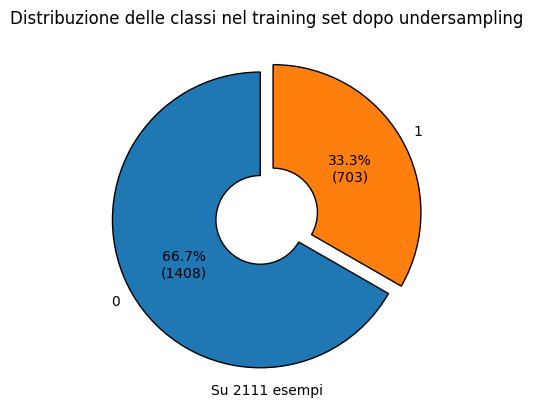

In [ ]:
target_features_number = dict(resized_y_train.value_counts())

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
        autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(resized_X_train))})",
        startangle=90,
        wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
        explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel training set dopo undersampling")
plt.text(0, -1.2, f"Su {len(resized_X_train)} esempi", ha='center')
plt.show()


### Oversampling per la classe maggioritaria

In [ ]:
pos_proportion = 0.4    # percentuale della classe positiva che vogliamo ottenere dall'oversampling (pos / (pos + neg))

pos_to_neg_proportion = pos_proportion / (1 - pos_proportion)   # rapporto tra le classi positiva e negativa che vogliamo ottenere (pos / neg)
pos_elem_to_generate = round(target_features_number[0] - target_features_number[1] * (1 - pos_proportion) / pos_proportion)   # numero di elementi negativi da rimuovere
print(f"Desired proportion of positive examples: {pos_proportion:.3f} --> pos / (pos + neg)")
print(f"Desired proportion of positive to negative examples: {pos_to_neg_proportion:.3f} --> pos / neg")
print(f"Positive examples to generate: {pos_elem_to_generate}, {pos_elem_to_generate / target_features_number[0] * 100:.1f}% of the actual positive examples")

Desired proportion of positive examples: 0.400 --> pos / (pos + neg)
Desired proportion of positive to negative examples: 0.667 --> pos / neg
Positive examples to generate: 354, 25.1% of the actual positive examples


In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy=pos_to_neg_proportion, random_state=RANDOM_STATE)
resized_X_train, resized_y_train = oversampler.fit_resample(resized_X_train, resized_y_train)
resized_y_train.shape

(2346,)

In [ ]:
resized_y_train.value_counts()

0    1408
1     938
Name: labels, dtype: int64

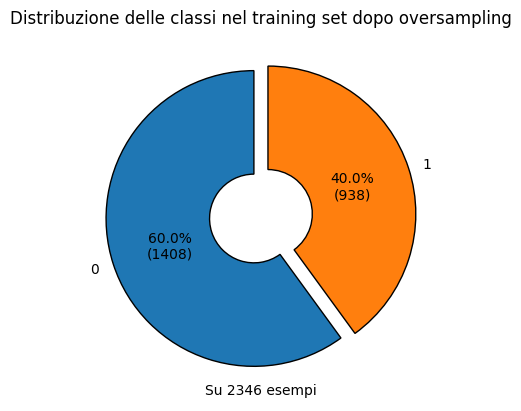

In [ ]:
target_features_number = dict(resized_y_train.value_counts())

plt.pie(target_features_number.values(), labels=target_features_number.keys(),
        autopct=lambda pct : f"{pct:.1f}%\n({round(pct/100*len(resized_X_train))})",
        startangle=90,
        wedgeprops=dict(edgecolor=(0, 0, 0, 1), width=0.7),
        explode=[0.05, 0.05])

plt.title("Distribuzione delle classi nel training set dopo oversampling")
plt.text(0, -1.2, f"Su {len(resized_X_train)} esempi", ha='center')
plt.show()

## __PCA__ - Principal Components Analysis

Percentuali di __varianza spiegata__ di riferimento:

In [ ]:
target_var = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

Calcolo della varianza spiegata da ogni componente:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(resized_X_train)

### Analisi del numero ottimale di componenti da utilizzare:

Varianza spiegata: 0.6 -> Componenti necessarie: 4
Varianza spiegata: 0.7 -> Componenti necessarie: 9
Varianza spiegata: 0.8 -> Componenti necessarie: 24
Varianza spiegata: 0.9 -> Componenti necessarie: 84
Varianza spiegata: 0.95 -> Componenti necessarie: 195
Varianza spiegata: 0.99 -> Componenti necessarie: 615


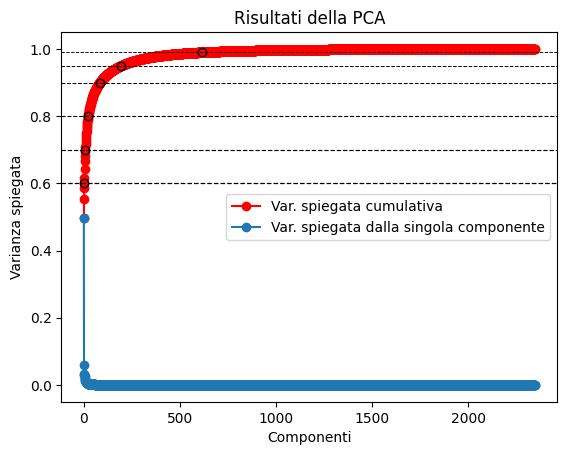

In [ ]:
tot_var_explained = []
prev_var_explained = 0
n_comp_for_target_var = []

for i, comp_var_explained in enumerate(pca.explained_variance_ratio_):
    tot_var_explained.append(prev_var_explained + comp_var_explained)
    prev_var_explained += comp_var_explained
    if len(n_comp_for_target_var) < len(target_var) and prev_var_explained >= target_var[len(n_comp_for_target_var)]:
        n_comp_for_target_var.append(i + 1)

for var, n_comp in zip(target_var, n_comp_for_target_var):
    print("Varianza spiegata: {} -> Componenti necessarie: {}".format(var, n_comp))

# Crea un grafico della varianza spiegata per ogni componente
plt.plot(range(1, pca.n_components_ + 1), tot_var_explained, marker='o', color='red', label="Var. spiegata cumulativa")
for i, crit_val in enumerate(n_comp_for_target_var):
    plt.plot(crit_val, target_var[i], marker='o', color='red', markeredgecolor='black')

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', label="Var. spiegata dalla singola componente")
for i, var in enumerate(target_var):
    plt.axhline(y=var, color='black', linestyle='--', linewidth=0.9 - i * 0.05)

plt.xlabel('Componenti')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.legend()

plt.show()

In [ ]:
assert abs(sum(pca.explained_variance_ratio_) - 1) <= EPSILON, "La somma della varianza spiegata dalle singole componenti non è 1"

In [ ]:
max_component_index = 3

max_var_n_comp = n_comp_for_target_var[max_component_index]
max_var_n_comp

84

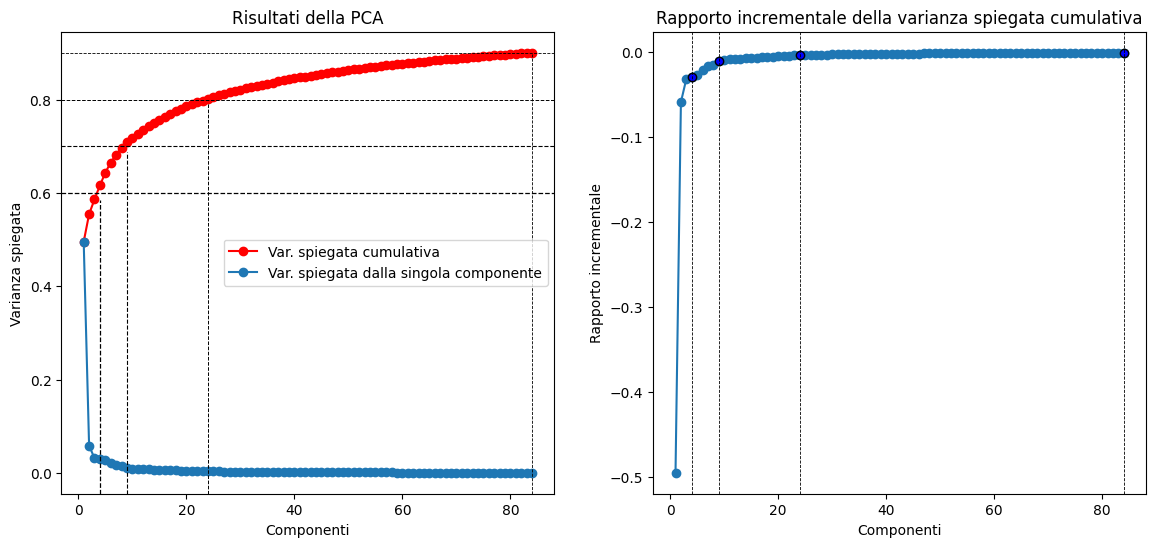

In [ ]:
tot_var_explained = []
prev_var_explained = 0
incr_ratio = []

for i in range(max_var_n_comp):
    comp_var_explained = pca.explained_variance_ratio_[i]
    tot_var_explained.append(prev_var_explained + comp_var_explained)
    if i > 0:
        incr_ratio.append(tot_var_explained[-2] - tot_var_explained[-1])
    else:
        incr_ratio.append(0 - tot_var_explained[-1])
    prev_var_explained += comp_var_explained

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Crea un grafico della varianza spiegata per ogni componente
ax[0].plot(range(1, max_var_n_comp + 1), tot_var_explained, marker='o', color='red', label="Var. spiegata cumulativa")
ax[0].plot(range(1, max_var_n_comp + 1), pca.explained_variance_ratio_[:max_var_n_comp], marker='o', label="Var. spiegata dalla singola componente")
for i, var in enumerate(target_var[:max_component_index + 1]):
    ax[0].axhline(y=var, color='black', linestyle='--', linewidth=0.9 - i * 0.1)
    ax[0].axvline(x=n_comp_for_target_var[i], ymax=var/ax[0].get_ylim()[1], color='black', linestyle='--', linewidth=0.9 - i * 0.1)

ax[0].set_xlabel('Componenti')
ax[0].set_ylabel('Varianza spiegata')
ax[0].set_title("Risultati della PCA")
ax[0].legend()

# Crea un grafico del rapporto incrementale per ogni componente
ax[1].plot(range(1, max_var_n_comp + 1), incr_ratio, marker='o', label="Rapporto incrementale")
for crit_val in n_comp_for_target_var[:max_component_index + 1]:
    ax[1].plot(crit_val, incr_ratio[crit_val - 1], marker='o', color='blue', markeredgecolor='black')
    ax[1].axvline(x=crit_val, color='black', linestyle='--', linewidth=0.9 - i * 0.1)
ax[1].set_xlabel('Componenti')
ax[1].set_ylabel('Rapporto incrementale')
ax[1].set_title("Rapporto incrementale della varianza spiegata cumulativa")

plt.show()

Analisi numerica del numero di componenti:

In [ ]:
APPROX = 6

data = []
for i, ratio in enumerate([0 - incr_ratio[0]] + [incr_ratio[i+1] - incr_ratio[i] for i in range(len(incr_ratio) - 1)]):
    data.append([i+1, round(tot_var_explained[i], APPROX), round(incr_ratio[i], APPROX), round(ratio, APPROX)])

df = pd.DataFrame(data, columns=['Numero di componenti', 'Varianza spiegata cumulativa', 'Derivata prima', 'Derivata seconda'])
df

,Numero di componenti,Varianza spiegata cumulativa,Derivata prima,Derivata seconda
0,1,0.495518,-0.495518,0.495518
1,2,0.554458,-0.058940,0.436578
2,3,0.586195,-0.031737,0.027203
3,4,0.615935,-0.029740,0.001998
4,5,0.643397,-0.027462,0.002277
...,...,...,...,...
79,80,0.897002,-0.000836,0.000026
80,81,0.897835,-0.000834,0.000002
81,82,0.898664,-0.000829,0.000005
82,83,0.899478,-0.000814,0.000015


In [ ]:
pca = PCA(n_components=max_var_n_comp).fit(resized_X_train)

Riepilogo dei valori di __varianza spiegata__ dalle componenti selezionate. Le colonne 1 e 2 dovrebbero coincidere a meno di errori di approsimazione: la differenza deriva dalle __operazioni di bilanciamento__ del dataset.

In [ ]:
eigenvalues = pca.explained_variance_
n_samples = resized_X_train.shape[0]
cov_matrix = np.dot(resized_X_train.T, resized_X_train) / n_samples

data = []
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):
    data.append([np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)), eigenvalue])

df_eigen = pd.DataFrame(data, columns=['Covarianza', 'Autovalore'])
df_eigen['Autovalore normalizzato'] = df_eigen['Autovalore'] / df_eigen['Autovalore'].sum()
df_eigen['Somma cumulativa'] = df_eigen['Autovalore normalizzato'].cumsum()

df_eigen

,Covarianza,Autovalore,Autovalore normalizzato,Somma cumulativa
0,3110.368254,3105.914751,0.550451,0.550451
1,377.428922,369.438163,0.065474,0.615925
2,198.874590,198.930187,0.035256,0.651181
3,186.352132,186.408674,0.033037,0.684218
4,173.262389,172.135005,0.030507,0.714725
...,...,...,...,...
79,5.218238,5.217535,0.000925,0.996405
80,5.163294,5.165495,0.000915,0.997320
81,5.155710,5.154344,0.000913,0.998234
82,5.004490,5.006420,0.000887,0.999121


In [ ]:
assert abs(sum(df_eigen['Autovalore normalizzato']) - 1) <= EPSILON, "La somma degli autovalori normalizzati non è 1"

Estrazione del numero di componenti finale:

In [ ]:
n_components = 84

In [ ]:
pca = PCA(n_components=n_components).fit(resized_X_train)

### Trasformazione dei vari __set__ nelle componenti selezionate

__Training set__:

In [ ]:
pca_X_train = pca.transform(resized_X_train)
pca_X_train.shape

(2346, 84)

Ricerca di eventuali correlazioni tra le componenti del __training set__ dopo la pca:

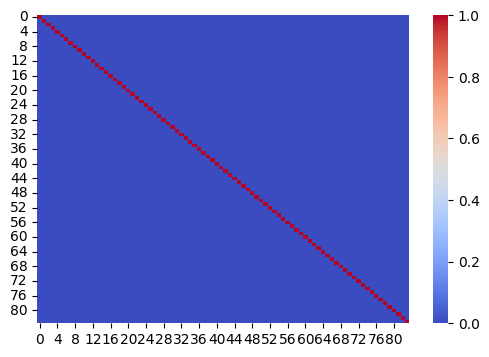

In [ ]:
correlation_matrix = pd.DataFrame(pca_X_train).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

__Validation set__

In [ ]:
pca_X_val = pca.transform(X_val)
pca_X_val.shape

(801, 84)

Ricerca di eventuali correlazioni tra le componenti del __validation set__ dopo la pca:

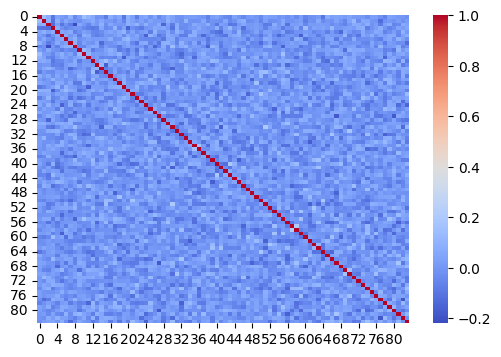

In [ ]:
correlation_matrix = pd.DataFrame(pca_X_val).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

__Test set__

In [ ]:
pca_X_test = pca.transform(X_test)
pca_X_test.shape

(400, 84)

Ricerca di eventuali correlazioni tra le componenti del __test set__ dopo la pca:

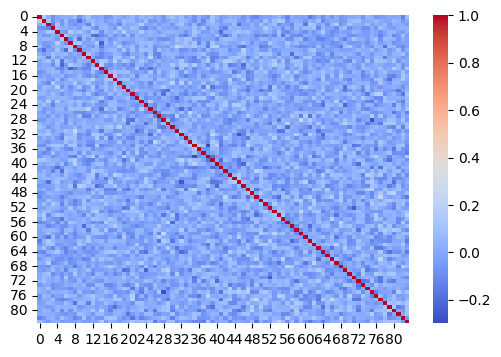

In [ ]:
correlation_matrix = pd.DataFrame(pca_X_test).corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
assert resized_y_train.shape[0] == pca_X_train.shape[0], "Il numero di esempi nel training set dopo la PCA è diverso dal numero di labels"

In [ ]:
assert y_val.shape[0] == pca_X_val.shape[0], "Il numero di esempi nel validation set dopo la PCA è diverso dal numero di labels"

In [ ]:
assert y_test.shape[0] == pca_X_test.shape[0], "Il numero di esempi nel test set dopo la PCA è diverso dal numero di labels"

## __Modello 1__ - __Rete neurale__

Rete neurale con _uno strato nascosto_:
 - __Funzione di loss__ per l'addestramento: ___binary crossentropy___;
 - __Funzione di attivazione__ per lo strato di ouput: ___sigmoid___.

Per tutti gli altri _iperparametri_ verrà fatta una ricerca degli ottimi.

### Impostazione dei __random seed__ per la riproducibilità degli addestramenti

In [ ]:
import tensorflow as tf

tf.random.set_seed(RANDOM_STATE)

### Ricerca della migliore __funzione di attivazione__ per lo strato nascosto

Si eseguono diverse prove facendo variare la __funzione di attivazione__ dello __strato nascosto__.

In [ ]:
activations_avaible = ['exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'elu', 'gelu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'swish', 'tanh', 'mish']
activations_accuracy = []
epochs = 10
batch_size = 15
hidden_layer_nodes = n_components//2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)  # Arresta l'addestramento se la loss sulla validation set non migliora per 5 epoche consecutive

activations_accuracy = []
activations_explained_variance = []

for i, activation in enumerate(activations_avaible):
    print(f"Testing activation function: {activation} ({i+1}/{len(activations_avaible)}):", end="\r")
    model = Sequential()
    model.add(Dense(hidden_layer_nodes, input_shape=(n_components,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_data=(pca_X_val, y_val))

    y_pred = model.predict(pca_X_val)
    threshold = 0.5
    y_pred = (y_pred > threshold).astype(int)
    activations_accuracy.append(accuracy_score(y_val, y_pred))
    activations_explained_variance.append(explained_variance_score(y_val, y_pred))
    print(f"Activation: {activation}, Accuracy: {activations_accuracy[-1]:.3f}, Explained Variance: {activations_explained_variance[-1]:.3f}")

26/26 [==============================] - 0s 2ms/step
Activation: exponential, Accuracy: 0.757, Explained Variance: 0.000
26/26 [==============================] - 0s 2ms/step
Activation: hard_sigmoid, Accuracy: 0.914, Explained Variance: 0.539
26/26 [==============================] - 0s 3ms/step
Activation: linear, Accuracy: 0.870, Explained Variance: 0.297
26/26 [==============================] - 0s 3ms/step
Activation: relu, Accuracy: 0.936, Explained Variance: 0.660
26/26 [==============================] - 0s 2ms/step
Activation: selu, Accuracy: 0.948, Explained Variance: 0.717
26/26 [==============================] - 0s 3ms/step
Activation: elu, Accuracy: 0.940, Explained Variance: 0.677
26/26 [==============================] - 0s 2ms/step
Activation: gelu, Accuracy: 0.931, Explained Variance: 0.631
26/26 [==============================] - 0s 2ms/step
Activation: sigmoid, Accuracy: 0.916, Explained Variance: 0.550
26/26 [==============================] - 0s 2ms/step
Activation: soft

In [ ]:
threshold = 0.985
max_accuracy = max(activations_accuracy)
best_activations_quad = [(activations_avaible[i], acc, expl) for i, (acc, expl) in enumerate(zip(activations_accuracy, activations_explained_variance)) if acc >= max_accuracy * threshold]

for activation, accuracy, expl in best_activations_quad:
    print(f"{activation}: Accuracy = {accuracy:.4f} --> {accuracy / max_accuracy:.3f} of max accuracy, explained variance = {expl:.3f}")

relu: Accuracy = 0.9363 --> 0.987 of max accuracy, explained variance = 0.660
selu: Accuracy = 0.9476 --> 0.999 of max accuracy, explained variance = 0.717
elu: Accuracy = 0.9401 --> 0.991 of max accuracy, explained variance = 0.677
softplus: Accuracy = 0.9488 --> 1.000 of max accuracy, explained variance = 0.723
swish: Accuracy = 0.9476 --> 0.999 of max accuracy, explained variance = 0.718
mish: Accuracy = 0.9488 --> 1.000 of max accuracy, explained variance = 0.724


In [ ]:
batch_size = 5
hidden_layer_nodes = [n_components//2 - 5, n_components//2, n_components//2 + 5]
epochs = 10

target_metric_str = "f1"

best_activations, best_activations_accuracy, best_activations_explained_var = zip(*best_activations_quad)
best_activations

('relu', 'selu', 'elu', 'softplus', 'swish', 'mish')

In [ ]:
from sklearn.metrics import f1_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

activations_best_parameters = []

for i, activation in enumerate(best_activations):
    print(f"Testing activation function: {activation} ({i+1}/{len(best_activations)})")
    target_metric, best_nodes = 0, 0
    for j, nodes in enumerate(hidden_layer_nodes):
        print(f"Testing with {nodes} hidden nodes ({j+1}/{len(hidden_layer_nodes)})", end="\r")
        model = Sequential()
        model.add(Dense(nodes, input_shape=(n_components,), activation=activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(pca_X_val, y_val), callbacks=[early_stopping])

        y_pred = model.predict(pca_X_val)
        threshold = 0.5
        y_pred = (y_pred > threshold).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > target_metric:
            target_metric = f1
            accuracy = accuracy_score(y_val, y_pred)
            explained_variance = explained_variance_score(y_val, y_pred)
            best_nodes = nodes
    activations_best_parameters.append((activation, target_metric, accuracy, explained_variance, best_nodes ))
    print(f"Best {target_metric_str}: {target_metric:.3f} with {best_nodes} hidden nodes, Accuracy = {accuracy:.3f}, explained variance = {explained_variance:.3f}")

Testing activation function: relu (1/6)
26/26 [==============================] - 0s 4ms/step
Best f1: 0.925 with 47 hidden nodes, Accuracy = 0.963, explained variance = 0.797
Testing activation function: selu (2/6)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.911 with 42 hidden nodes, Accuracy = 0.955, explained variance = 0.758
Testing activation function: elu (3/6)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.922 with 47 hidden nodes, Accuracy = 0.961, explained variance = 0.791
Testing activation function: softplus (4/6)
26/26 [==============================] - 0s 4ms/step
Best f1: 0.898 with 37 hidden nodes, Accuracy = 0.949, explained variance = 0.724
Testing activation function: swish (5/6)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.914 with 42 hidden nodes, Accuracy = 0.956, explained variance = 0.765
Testing activation function: mish (6/6)
26/26 [==============================] - 0s 2ms/step
Best f1: 0.906 with 37 hidde

In [ ]:
activations_best_parameters

[('relu', 0.9246231155778895, 0.9625468164794008, 0.7971904882795972, 47),
 ('selu', 0.9108910891089109, 0.9550561797752809, 0.7576373021917576, 42),
 ('elu', 0.9223057644110275, 0.9612983770287141, 0.7905559786747905, 47),
 ('softplus', 0.8982630272952854, 0.9488139825218477, 0.7235169670813234, 37),
 ('swish', 0.9135802469135802, 0.9563046192259675, 0.7646610814927647, 42),
 ('mish', 0.9064039408866996, 0.9525593008739076, 0.7445883049843445, 37)]

In [ ]:
activations, target_metric, accuracy, explained_var, nodes = zip(*activations_best_parameters)

In [ ]:
best_index_metrics = np.argmax(target_metric)
best_activation_function, target_metric, accuracy, explained_var, best_nodes = activations_best_parameters[best_index_metrics]
print(f"Best activation function is: {best_activation_function} with {best_nodes} hidden nodes --> Accuracy = {accuracy}, F1 = {target_metric}, Explained Variance = {explained_var}")

Best activation function is: relu with 47 hidden nodes --> Accuracy = 0.9625468164794008, F1 = 0.9246231155778895, Explained Variance = 0.7971904882795972


A causa di fattori casuali della libreria __keras__ (come la inizializzazione dei pesi), la migliore funzione di attivazione può variare da esecuzione a esecuzione. Per questo viene scelta la funzione ___mish___, quella che ha dato risultati migliori negli esperimenti eseguiti.

In [ ]:
best_activation_function = 'mish'
best_activation_function

'mish'

### Ricerca della migliore __architettura__ per lo strato nascosto della rete
Si eseguono diverse prove facendo variare il __numero di nodi__ dello __strato nascosto__.

In [ ]:
epochs = 50
batch_size = 5
patience = 10

base_cardinality = n_components//2
lower_bound = base_cardinality//2
upper_bound = 3 * (base_cardinality//2)
multiplier = 5

hidden_layer_nodes = [hidden_nodes for hidden_nodes in range(lower_bound, upper_bound, multiplier)]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience)  # Arresta l'addestramento se la loss sulla validation set non migliora per _patience_ epoche consecutive

accuracy = []
recall = []
precision = []
f1 = []
explained_variance = []
best_epochs = []

for i, nodes in enumerate(hidden_layer_nodes):
    print(f"Testing hidden layer dimension: {nodes} ({i+1}/{len(hidden_layer_nodes)})")
    model = Sequential()
    model.add(Dense(nodes, input_shape=(n_components,), activation=best_activation_function)) # nodes=#nodi strato nascosto, varia di iterazione in iterazione
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_data=(pca_X_val, y_val))
    best_epochs.append(len(history.history['val_loss']))

    y_pred = model.predict(pca_X_val)
    threshold = 0.5
    y_pred = (y_pred > threshold).astype(int)

    accuracy.append(accuracy_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    precision.append(precision_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))
    explained_variance.append(explained_variance_score(y_val, y_pred))

    print(f'Hidden nodes: {nodes}, Best epochs: {best_epochs[-1]},  Accuracy: {accuracy[-1]}, F1: {f1[-1]}, Explained Variance: {explained_variance[-1]}')

Testing hidden layer dimension: 21 (1/9)
26/26 [==============================] - 0s 5ms/step
Hidden nodes: 21, Best epochs: 21,  Accuracy: 0.947565543071161, F1: 0.8949999999999999, Explained Variance: 0.7161546923923161
Testing hidden layer dimension: 26 (2/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 26, Best epochs: 17,  Accuracy: 0.9438202247191011, F1: 0.8899755501222495, Explained Variance: 0.698028264364898
Testing hidden layer dimension: 31 (3/9)
26/26 [==============================] - 0s 3ms/step
Hidden nodes: 31, Best epochs: 21,  Accuracy: 0.951310861423221, F1: 0.9032258064516129, Explained Variance: 0.737073707370737
Testing hidden layer dimension: 36 (4/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 36, Best epochs: 16,  Accuracy: 0.947565543071161, F1: 0.8975609756097562, Explained Variance: 0.7186934078023186
Testing hidden layer dimension: 41 (5/9)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 41, B

In [ ]:
for i, nodes in enumerate(hidden_layer_nodes):
    print(f'Hidden nodes: {nodes}, epochs: {best_epochs[i]}, Accuracy: {accuracy[i]}, Recall: {recall[i]}, Precision: {precision[i]}, F1: {f1[i]}, Explained variance score: {explained_variance[i]}')

Hidden nodes: 21, epochs: 21, Accuracy: 0.947565543071161, Recall: 0.9179487179487179, Precision: 0.8731707317073171, F1: 0.8949999999999999, Explained variance score: 0.7161546923923161
Hidden nodes: 26, epochs: 17, Accuracy: 0.9438202247191011, Recall: 0.9333333333333333, Precision: 0.8504672897196262, F1: 0.8899755501222495, Explained variance score: 0.698028264364898
Hidden nodes: 31, epochs: 21, Accuracy: 0.951310861423221, Recall: 0.9333333333333333, Precision: 0.875, F1: 0.9032258064516129, Explained variance score: 0.737073707370737
Hidden nodes: 36, epochs: 16, Accuracy: 0.947565543071161, Recall: 0.9435897435897436, Precision: 0.8558139534883721, F1: 0.8975609756097562, Explained variance score: 0.7186934078023186
Hidden nodes: 41, epochs: 16, Accuracy: 0.9488139825218477, Recall: 0.9333333333333333, Precision: 0.8666666666666667, F1: 0.8987654320987654, Explained variance score: 0.723990860624524
Hidden nodes: 46, epochs: 24, Accuracy: 0.9625468164794008, Recall: 0.928205128

In [ ]:
best_nodes = hidden_layer_nodes[np.argmax(f1)]
best_nodes

46

In [ ]:
epochs = 50
batch_size = 5
patience = 10
multiplier_2 = 2

hidden_layer_nodes = [best_nodes + i for i in range(1 - multiplier, multiplier, multiplier_2)]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience)  # Arresta l'addestramento se la loss sulla validation set non migliora per _patience_ epoche consecutive

accuracy = []
recall = []
precision = []
f1 = []
explained_variance = []
best_epochs = []

for i, nodes in enumerate(hidden_layer_nodes):
    print(f"Testing hidden layer dimesions: {nodes} ({i+1}/{len(hidden_layer_nodes)})")
    model = Sequential()
    model.add(Dense(nodes, input_shape=(n_components,), activation=best_activation_function)) # nodes = #nodi strato nascosto, varia di iterazione in iterazione
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(pca_X_train, resized_y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping], validation_data=(pca_X_val, y_val))
    best_epochs.append(len(history.history['val_loss']))

    y_pred = model.predict(pca_X_val)
    threshold = 0.5
    y_pred = (y_pred > threshold).astype(int)

    accuracy.append(accuracy_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    precision.append(precision_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))
    explained_variance.append(explained_variance_score(y_val, y_pred))

    print(f'Hidden nodes: {nodes}, Best epochs: {best_epochs[-1]},  Accuracy: {accuracy[-1]}, F1: {f1[-1]}, Explained Variance: {explained_variance[-1]}')

Testing hidden layer dimesions: 42 (1/5)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 42, Best epochs: 16,  Accuracy: 0.9488139825218477, F1: 0.8982630272952854, Explained Variance: 0.7235169670813235
Testing hidden layer dimesions: 44 (2/5)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 44, Best epochs: 24,  Accuracy: 0.9600499375780275, F1: 0.9195979899497487, Explained Variance: 0.7836337479901836
Testing hidden layer dimesions: 46 (3/5)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 46, Best epochs: 14,  Accuracy: 0.9488139825218477, F1: 0.8972431077694235, Explained Variance: 0.7227722772277227
Testing hidden layer dimesions: 48 (4/5)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 48, Best epochs: 24,  Accuracy: 0.951310861423221, F1: 0.9037037037037037, Explained Variance: 0.7375476009139375
Testing hidden layer dimesions: 50 (5/5)
26/26 [==============================] - 0s 2ms/step
Hidden nodes: 5

In [ ]:
for i, nodes in enumerate(hidden_layer_nodes):
    print(f'Hidden nodes: {nodes}, epochs: {best_epochs[i]}, Accuracy: {accuracy[i]}, Recall: {recall[i]}, Precision: {precision[i]}, F1: {f1[i]}, Explained variance score: {explained_variance[i]}')

Hidden nodes: 42, epochs: 16, Accuracy: 0.9488139825218477, Recall: 0.9282051282051282, Precision: 0.8701923076923077, F1: 0.8982630272952854, Explained variance score: 0.7235169670813235
Hidden nodes: 44, epochs: 24, Accuracy: 0.9600499375780275, Recall: 0.9384615384615385, Precision: 0.9014778325123153, F1: 0.9195979899497487, Explained variance score: 0.7836337479901836
Hidden nodes: 46, epochs: 14, Accuracy: 0.9488139825218477, Recall: 0.9179487179487179, Precision: 0.8774509803921569, F1: 0.8972431077694235, Explained variance score: 0.7227722772277227
Hidden nodes: 48, epochs: 24, Accuracy: 0.951310861423221, Recall: 0.9384615384615385, Precision: 0.8714285714285714, F1: 0.9037037037037037, Explained variance score: 0.7375476009139375
Hidden nodes: 50, epochs: 17, Accuracy: 0.9550561797752809, Recall: 0.9384615384615385, Precision: 0.8840579710144928, F1: 0.9104477611940298, Explained variance score: 0.7571972581873572


In [ ]:
target_metric_best_index = np.argmax(f1)
print(f"Best hidden nodes number: {hidden_layer_nodes[target_metric_best_index]}, epochs: {best_epochs[target_metric_best_index]}, Accuracy: {accuracy[target_metric_best_index]}, Recall: {recall[target_metric_best_index]}, Precision: {precision[target_metric_best_index]}, F1: {f1[target_metric_best_index]}, Explained variance score: {explained_variance[target_metric_best_index]}")

Best hidden nodes number: 44, epochs: 24, Accuracy: 0.9600499375780275, Recall: 0.9384615384615385, Precision: 0.9014778325123153, F1: 0.9195979899497487, Explained variance score: 0.7836337479901836


In [ ]:
best_nodes = hidden_layer_nodes[target_metric_best_index]

In [ ]:
batch_size = 5
epochs = best_epochs[target_metric_best_index]

Vengono fissati anche il numero di nodi e di epoche ottimale in base a quanto riscontrato durante gli esperimenti:

In [ ]:
best_nodes, epochs = 53, 22
best_nodes, epochs, best_activation_function

(53, 22, 'mish')

### __Stratified 10-fold cross validation__

Ricostruzione del __training_val_set__ (__training set + validation set__):

In [ ]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
y = y_train_val

In [ ]:
assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

In [ ]:
pca_cross_dataset = pca.transform(X_train_val)
df = pd.DataFrame(data=pca_cross_dataset)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

test_pred_proba = np.zeros((df.shape[0], 2))
accuracy_k_fold_nn = []
recall_k_fold_nn = []
precision_k_fold_nn = []
f1_k_fold_nn = []
explained_variance_k_fold_nn = []

training_times_nn = []
evaluation_times_nn = []

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

resample = False
undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

for n_fold, (train_idx, val_test_idx) in enumerate(folds.split(df, y)):
        X_cross_train, X_cross_val = df.iloc[train_idx], df.iloc[val_test_idx]
        y_cross_train, y_cross_val = y[train_idx], y[val_test_idx]

        if resample:
                X_cross_train, y_cross_train = undersampler.fit_resample(X_cross_train, y_cross_train)
                X_cross_train, y_cross_train = oversampler.fit_resample(X_cross_train, y_cross_train)

        model = Sequential()
        model.add(Dense(best_nodes, input_shape=(n_components,), activation=best_activation_function))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        tic = time.time()
        model.fit(X_cross_train, y_cross_train, epochs=epochs, batch_size=batch_size,
                  verbose=0, validation_data=(X_cross_val, y_cross_val), callbacks=[early_stopping])
        training_times_nn.append(time.time() - tic)

        tic = time.time()
        y_cross_pred_valid = model.predict(X_cross_val)
        evaluation_times_nn.append(time.time() - tic)

        threshold = 0.5
        y_cross_pred_valid = (y_cross_pred_valid > threshold).astype(int)

        accuracy_k_fold_nn.append(accuracy_score(y_cross_val, y_cross_pred_valid))
        recall_k_fold_nn.append(recall_score(y_cross_val, y_cross_pred_valid))
        precision_k_fold_nn.append(precision_score(y_cross_val, y_cross_pred_valid))
        f1_k_fold_nn.append(f1_score(y_cross_val, y_cross_pred_valid))
        explained_variance_k_fold_nn.append(explained_variance_score(y_cross_val, y_cross_pred_valid))

        print(f'Fold {n_fold + 1}, Accuracy: {accuracy_k_fold_nn[-1]:.3f}, F1: {f1_k_fold_nn[-1]:.3f}, Explained Variance: {explained_variance_k_fold_nn[-1]:.3f}', end=", ")
        print(f'Training time: {training_times_nn[-1]:.3f}, Evaluation time: {evaluation_times_nn[-1]:.3f}')

12/12 [==============================] - 0s 3ms/step
Fold 1, Accuracy: 0.978, F1: 0.954, Explained Variance: 0.881, Training time: 29.313, Evaluation time: 12.785
12/12 [==============================] - 0s 2ms/step
Fold 2, Accuracy: 0.969, F1: 0.938, Explained Variance: 0.836, Training time: 13.916, Evaluation time: 7.521
12/12 [==============================] - 0s 3ms/step
Fold 3, Accuracy: 0.972, F1: 0.944, Explained Variance: 0.852, Training time: 17.697, Evaluation time: 0.261
12/12 [==============================] - 0s 2ms/step
Fold 4, Accuracy: 0.969, F1: 0.941, Explained Variance: 0.838, Training time: 16.445, Evaluation time: 0.163
12/12 [==============================] - 0s 4ms/step
Fold 5, Accuracy: 0.972, F1: 0.944, Explained Variance: 0.852, Training time: 15.004, Evaluation time: 6.407
12/12 [==============================] - 0s 2ms/step
Fold 6, Accuracy: 0.969, F1: 0.939, Explained Variance: 0.837, Training time: 18.217, Evaluation time: 3.628
12/12 [====================

Metriche sul __validation test__ per la __stratified cross validation__:

In [ ]:
print(f"Tempo medio di addestramento: {np.mean(training_times_nn):.2f} secondi")
print(f"Tempo medio di inferenza: {np.mean(evaluation_times_nn):.2f} secondi")

Tempo medio di addestramento: 20.75 secondi
Tempo medio di inferenza: 3.81 secondi


In [ ]:
accuracy = np.mean(accuracy_k_fold_nn)
recall = np.mean(recall_k_fold_nn)
precision = np.mean(precision_k_fold_nn)
f1 = np.mean(f1_k_fold_nn)
explained_variance = np.mean(explained_variance_k_fold_nn)
print(f"Accuracy={accuracy:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Explained Variance={explained_variance:.3f}")

Accuracy=0.969, Recall=0.937, Precision=0.941, F1=0.939, Explained Variance=0.837


In [ ]:
confidence = 0.95

Intervalli di confidenza per tutte le metriche:

In [ ]:
import scipy.stats as stats

print(f"Accuracy {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(accuracy_k_fold_nn)-1, loc=np.mean(accuracy_k_fold_nn), scale=stats.sem(accuracy_k_fold_nn))}")
print(f"Recall {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(recall_k_fold_nn)-1, loc=np.mean(recall_k_fold_nn), scale=stats.sem(recall_k_fold_nn))}")
print(f"Precision {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(precision_k_fold_nn)-1, loc=np.mean(precision_k_fold_nn), scale=stats.sem(precision_k_fold_nn))}")
print(f"F1 {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(f1_k_fold_nn)-1, loc=np.mean(f1_k_fold_nn), scale=stats.sem(f1_k_fold_nn))}")
print(f"Explained Variance {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(explained_variance_k_fold_nn)-1, loc=np.mean(explained_variance_k_fold_nn), scale=stats.sem(explained_variance_k_fold_nn))}")

Accuracy 0.95 confidence interval: (0.9606571464880214, 0.9782317424008675)
Recall 0.95 confidence interval: (0.918904718297112, 0.9541289895680567)
Precision 0.95 confidence interval: (0.9195800984245757, 0.9628978043374048)
F1 0.95 confidence interval: (0.9213840457510774, 0.956031938659267)
Explained Variance 0.95 confidence interval: (0.7901996347728885, 0.8839303824240793)


### __Addestramento__ con l'intero __training set__

In [ ]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

In [ ]:
assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

In [ ]:
resample = True

undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_train_val, y_train_val = undersampler.fit_resample(X_train_val, y_train_val)
    X_train_val, y_train_val = oversampler.fit_resample(X_train_val, y_train_val)

In [ ]:
pca_train_dataset = pca.transform(X_train_val)

In [ ]:
model = Sequential()
model.add(Dense(best_nodes, input_shape=(n_components,), activation=best_activation_function))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tic = time.time()
model.fit(pca_train_dataset, y_train_val, epochs=epochs, batch_size=batch_size, verbose=1)
training_time = time.time() - tic

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/22
600/600 [==============================] - 2s 3ms/step - loss: 0.5311 - accuracy: 0.8401
Epoch 2/22
600/600 [==============================] - 2s 3ms/step - loss: 0.1649 - accuracy: 0.9383
Epoch 3/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0949 - accuracy: 0.9690
Epoch 4/22
600/600 [==============================] - 3s 4ms/step - loss: 0.0618 - accuracy: 0.9823
Epoch 5/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0398 - accuracy: 0.9913
Epoch 6/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0298 - accuracy: 0.9907
Epoch 7/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0251 - accuracy: 0.9923
Epoch 8/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0118 - accuracy: 0.9983
Epoch 9/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0071 - accuracy: 0.9997
Epoch 10/22
600/600 [==============================] - 2s 3ms/step - loss: 0.0051 - accuracy: 1.0000

### Valutazione sul __test set__

In [ ]:
y_test_pred_prob_nn = model.predict(pca_X_test) # questi valori saranno utili nella sezione test finale della svm, dove formeranno dei grafici congiunti con i rispettivi dati dell'svm
threshold = 0.5
y_test_pred_valid = (y_test_pred_prob_nn > threshold).astype(int)

accuracy = accuracy_score(y_test, y_test_pred_valid)
recall = recall_score(y_test, y_test_pred_valid)
precision = precision_score(y_test, y_test_pred_valid)
f1 = f1_score(y_test, y_test_pred_valid)
explained_variance = explained_variance_score(y_test, y_test_pred_valid)

print(f"Accuracy={accuracy:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Explained Variance={explained_variance:.3f}")

13/13 [==============================] - 0s 2ms/step
Accuracy=0.968, Recall=0.931, Precision=0.941, F1=0.936, Explained Variance=0.829


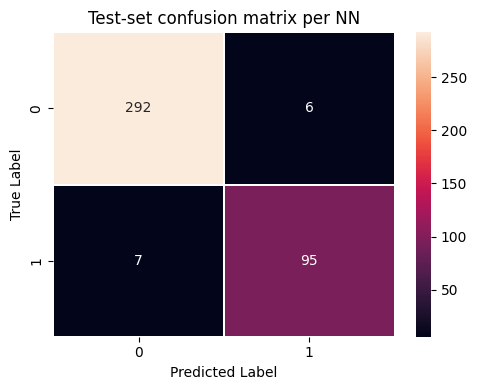

In [ ]:
confmat = confusion_matrix(y_test, y_test_pred_valid)
# Plot the confusion matrix
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confmat, annot=True, linewidths=0.02, cbar=True, fmt='.0f', ax=ax)

plt.title("Test-set confusion matrix per NN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Addestramento finale con l'intero __dataset__


In [ ]:
X_final_dataset = dataset.drop("labels", axis=1)
y_final_dataset = dataset["labels"]
X_final_dataset.shape

(4000, 6400)

In [ ]:
assert X_final_dataset.shape[0] == y_final_dataset.shape[0], "Final dataset and labels have different number of examples"

In [ ]:
resample = True

undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_final_dataset, y_final_dataset = undersampler.fit_resample(X_final_dataset, y_final_dataset)
    X_final_dataset, y_final_dataset = oversampler.fit_resample(X_final_dataset, y_final_dataset)

In [ ]:
pca_final_dataset = pca.transform(X_final_dataset)

In [ ]:
model = Sequential()
model.add(Dense(best_nodes, input_shape=(n_components,), activation=best_activation_function))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(pca_final_dataset, y_final_dataset, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/22
668/668 [==============================] - 3s 3ms/step - loss: 0.5447 - accuracy: 0.8607
Epoch 2/22
668/668 [==============================] - 2s 3ms/step - loss: 0.1378 - accuracy: 0.9503
Epoch 3/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0786 - accuracy: 0.9757
Epoch 4/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0564 - accuracy: 0.9820
Epoch 5/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0352 - accuracy: 0.9886
Epoch 6/22
668/668 [==============================] - 2s 4ms/step - loss: 0.0285 - accuracy: 0.9913
Epoch 7/22
668/668 [==============================] - 3s 4ms/step - loss: 0.0156 - accuracy: 0.9973
Epoch 8/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0177 - accuracy: 0.9952
Epoch 9/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0156 - accuracy: 0.9946
Epoch 10/22
668/668 [==============================] - 2s 3ms/step - loss: 0.0139 - accuracy: 0.9952

### Salvataggio del modello su disco

Salvataggio dei pesi in formato _h5_:

In [ ]:
model.save_weights(NN_WEIGHTS_PATH)

Salvataggio delle configurazioni in formato _JSON_:

In [ ]:
with open(NN_CONFIG_PATH, "w") as json_file:
    json_file.write(model.to_json())

## __Modello 2 - SVM__

### Tuning iperparametri

In [ ]:
assert y_val.shape[0] == pca_X_val.shape[0], "Il numero di esempi nel validation set dopo la PCA è diverso dal numero di labels"

In [ ]:
from sklearn import svm
from sklearn.metrics import f1_score, explained_variance_score

kernels_avaible = ['linear', 'rbf', 'poly', 'sigmoid']
kernels_f1 = []
kernels_explained_variance = []
for i, kernel in enumerate(kernels_avaible):
    print(f"Testing kernels: {kernel} ({i+1}/{len(kernels_avaible)}):")
    # Crea il classificatore SVM
    clf = svm.SVC(kernel=kernel, C=1, random_state=RANDOM_STATE)

    # Addestra il classificatore
    clf.fit(pca_X_train, resized_y_train)
    # Effettua le predizioni sul validation set
    y_pred = clf.predict(pca_X_val) #array di booleani, grande quanto il num di righe di pca_X_val

    kernels_f1.append(f1_score(y_val, y_pred))

    kernels_explained_variance.append(explained_variance_score(y_val, y_pred))
    print(f"f1 score: {kernels_f1[-1]:.3f}, Explained Variance: {kernels_explained_variance[-1]:.3f}")

Testing kernels: linear (1/4):
f1 score: 0.761, Explained Variance: 0.316
Testing kernels: rbf (2/4):
f1 score: 0.877, Explained Variance: 0.664
Testing kernels: poly (3/4):
f1 score: 0.673, Explained Variance: 0.339
Testing kernels: sigmoid (4/4):
f1 score: 0.392, Explained Variance: -0.898


In [ ]:
best_kernel = kernels_avaible[np.argmax(kernels_f1)]
best_kernel

'rbf'

In [ ]:
C_avaible = range(1,10)
C_f1 = []
C_explained_variance = []
for i, C in enumerate(C_avaible):
    print(f"Testing C: {C} ({i+1}/{len(C_avaible)}):")
    # Crea il classificatore SVM
    clf = svm.SVC(kernel=best_kernel, C=C, random_state=RANDOM_STATE)

    # Addestra il classificatore
    clf.fit(pca_X_train, resized_y_train)
    # Effettua le predizioni sul validation set
    y_pred = clf.predict(pca_X_val) #array di booleani, grande quanto il num di righe di pca_X_val

    C_f1.append(f1_score(y_val, y_pred))

    C_explained_variance.append(explained_variance_score(y_val, y_pred))
    print(f"f1 score: {C_f1[-1]:.3f}, Explained Variance: {C_explained_variance[-1]:.3f}")

Testing C: 1 (1/9):
f1 score: 0.877, Explained Variance: 0.664
Testing C: 2 (2/9):
f1 score: 0.889, Explained Variance: 0.697
Testing C: 3 (3/9):
f1 score: 0.893, Explained Variance: 0.710
Testing C: 4 (4/9):
f1 score: 0.894, Explained Variance: 0.710
Testing C: 5 (5/9):
f1 score: 0.899, Explained Variance: 0.724
Testing C: 6 (6/9):
f1 score: 0.906, Explained Variance: 0.744
Testing C: 7 (7/9):
f1 score: 0.908, Explained Variance: 0.751
Testing C: 8 (8/9):
f1 score: 0.910, Explained Variance: 0.757
Testing C: 9 (9/9):
f1 score: 0.908, Explained Variance: 0.750


In [ ]:
best_C = C_avaible[np.argmax(C_f1)]
best_C

8

### __Stratified 10-fold cross validation__

In [ ]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
y = y_train_val

assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

pca_cross_dataset = pca.transform(X_train_val)
df = pd.DataFrame(data=pca_cross_dataset)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, explained_variance_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import time

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

test_pred_proba = np.zeros((df.shape[0], 2))
accuracy_k_fold_svm = []
recall_k_fold_svm = []
precision_k_fold_svm = []
f1_k_fold_svm = []
explained_variance_k_fold_svm = []

timesAddestramento_svm = []
timesInferenza_svm = []

resample = False
undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

for n_fold, (train_idx, val_test_idx) in enumerate(folds.split(df, y)):
        X_cross_train, X_cross_val = df.iloc[train_idx], df.iloc[val_test_idx]
        y_cross_train, y_cross_val = y[train_idx], y[val_test_idx]

        if resample:
                X_cross_train, y_cross_train = undersampler.fit_resample(X_cross_train, y_cross_train)
                X_cross_train, y_cross_train = oversampler.fit_resample(X_cross_train, y_cross_train)

        # Crea il classificatore SVM
        clf = svm.SVC(kernel=best_kernel, C=best_C, random_state=RANDOM_STATE)
        tic = time.time()

        # Addestra il classificatore
        clf.fit(X_cross_train, y_cross_train)
        timesAddestramento_svm.append(time.time() - tic)

        tic = time.time()
        #fai inferenza sui dati di validation
        y_cross_pred_valid = clf.predict(X_cross_val)
        timesInferenza_svm.append(time.time() - tic)

        accuracy_k_fold_svm.append(accuracy_score(y_cross_val, y_cross_pred_valid))
        recall_k_fold_svm.append(recall_score(y_cross_val, y_cross_pred_valid))
        precision_k_fold_svm.append(precision_score(y_cross_val, y_cross_pred_valid))
        f1_k_fold_svm.append(f1_score(y_cross_val, y_cross_pred_valid))
        explained_variance_k_fold_svm.append(explained_variance_score(y_cross_val, y_cross_pred_valid))

        print(f'Fold {n_fold + 1}, Accuracy: {accuracy_k_fold_svm[-1]:.3f}, F1: {f1_k_fold_svm[-1]:.3f}, Explained Variance: {explained_variance_k_fold_svm[-1]:.3f}', end=", ")
        print(f'Training time: {timesAddestramento_svm[-1]:.3f}, Evaluation time: {timesInferenza_svm[-1]:.3f}')

Fold 1, Accuracy: 0.969, F1: 0.936, Explained Variance: 0.837, Training time: 0.237, Evaluation time: 0.023
Fold 2, Accuracy: 0.969, F1: 0.938, Explained Variance: 0.836, Training time: 0.200, Evaluation time: 0.029
Fold 3, Accuracy: 0.972, F1: 0.944, Explained Variance: 0.852, Training time: 0.241, Evaluation time: 0.023
Fold 4, Accuracy: 0.981, F1: 0.962, Explained Variance: 0.897, Training time: 0.200, Evaluation time: 0.027
Fold 5, Accuracy: 0.964, F1: 0.928, Explained Variance: 0.807, Training time: 0.195, Evaluation time: 0.028
Fold 6, Accuracy: 0.947, F1: 0.897, Explained Variance: 0.720, Training time: 0.203, Evaluation time: 0.026
Fold 7, Accuracy: 0.958, F1: 0.917, Explained Variance: 0.778, Training time: 0.220, Evaluation time: 0.024
Fold 8, Accuracy: 0.978, F1: 0.955, Explained Variance: 0.882, Training time: 0.219, Evaluation time: 0.027
Fold 9, Accuracy: 0.953, F1: 0.903, Explained Variance: 0.749, Training time: 0.187, Evaluation time: 0.030
Fold 10, Accuracy: 0.975, F1

In [ ]:
print(f"Tempo medio di addestramento: {np.mean(timesAddestramento_svm):.2f} secondi")
print(f"Tempo medio di inferenza: {np.mean(timesInferenza_svm):.2f} secondi")

Tempo medio di addestramento: 0.21 secondi
Tempo medio di inferenza: 0.03 secondi


Metriche sul __validation test__ per la __stratified cross validation__:

In [ ]:
accuracy = np.mean(accuracy_k_fold_svm)
recall = np.mean(recall_k_fold_svm)
precision = np.mean(precision_k_fold_svm)
f1 = np.mean(f1_k_fold_svm)
explained_variance = np.mean(explained_variance_k_fold_svm)
print(f"Accuracy={accuracy:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Explained Variance={explained_variance:.3f}")

Accuracy=0.967, Recall=0.932, Precision=0.935, F1=0.933, Explained Variance=0.822


Intervalli di confidenza per tutte le metriche:

In [ ]:
confidence = 0.95

import scipy.stats as stats

print(f"Accuracy {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(accuracy_k_fold_svm)-1, loc=np.mean(accuracy_k_fold_svm), scale=stats.sem(accuracy_k_fold_svm))}")
print(f"Recall {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(recall_k_fold_svm)-1, loc=np.mean(recall_k_fold_svm), scale=stats.sem(recall_k_fold_svm))}")
print(f"Precision {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(precision_k_fold_svm)-1, loc=np.mean(precision_k_fold_svm), scale=stats.sem(precision_k_fold_svm))}")
print(f"F1 {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(f1_k_fold_svm)-1, loc=np.mean(f1_k_fold_svm), scale=stats.sem(f1_k_fold_svm))}") # dopo lo plottiamo pure
print(f"Explained Variance {confidence} confidence interval: {stats.t.interval(confidence=confidence, df=len(explained_variance_k_fold_svm)-1, loc=np.mean(explained_variance_k_fold_svm), scale=stats.sem(explained_variance_k_fold_svm))}")

Accuracy 0.95 confidence interval: (0.9588294286499874, 0.9745039046833457)
Recall 0.95 confidence interval: (0.9127157047137393, 0.951379176684513)
Precision 0.95 confidence interval: (0.9152865647827904, 0.9541881116997759)
F1 0.95 confidence interval: (0.9176058259758427, 0.9486447942375403)
Explained Variance 0.95 confidence interval: (0.780783241895628, 0.8639308306633251)


### __Addestramento__ con l'intero __training set__

In [ ]:
assert X_train_val.shape[0] == y_train_val.shape[0], "Training + validation set have different number of examples and labels"

resample = True
undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_train_val, y_train_val = undersampler.fit_resample(X_train_val, y_train_val)
    X_train_val, y_train_val = oversampler.fit_resample(X_train_val, y_train_val)

pca_train_dataset = pca.transform(X_train_val)

model = svm.SVC(kernel=best_kernel, C=best_C, random_state=RANDOM_STATE, probability=True) #nota il probability=True, perchè vogliamo (con la NN di sopra) output reale e non già sogliato sulla threshold che decide lui (ci serve dopo per le varie curve)

# Addestra il classificatore
model.fit(pca_train_dataset, y_train_val)

SVC(C=8, probability=True, random_state=57)

### Valutazione sul __test set__



In [ ]:
y_test_pred_prob_svm = model.predict_proba(pca_X_test)[:, 1]
threshold = 0.5
y_test_pred_valid = (y_test_pred_prob_svm > threshold).astype(int)

accuracy = accuracy_score(y_test, y_test_pred_valid)
recall = recall_score(y_test, y_test_pred_valid)
precision = precision_score(y_test, y_test_pred_valid)
f1 = f1_score(y_test, y_test_pred_valid)
explained_variance = explained_variance_score(y_test, y_test_pred_valid)

print(f"Accuracy={accuracy:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Explained Variance={explained_variance:.3f}")

Accuracy=0.953, Recall=0.931, Precision=0.888, F1=0.909, Explained Variance=0.751


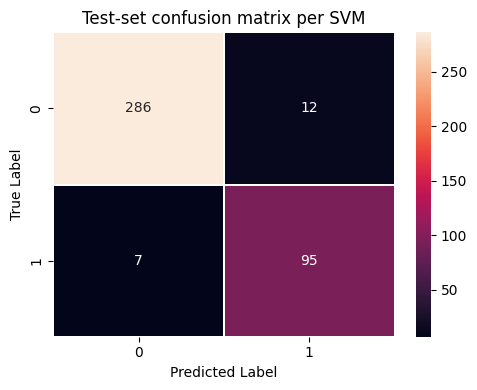

In [ ]:
confmat = confusion_matrix(y_test, y_test_pred_valid)
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(confmat, annot=True, linewidths=0.02, cbar=True, fmt='.0f', ax=ax)

plt.title("Test-set confusion matrix per SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Addestramento finale con l'intero __dataset__

In [ ]:
X_final_dataset = dataset.drop("labels", axis=1)
y_final_dataset = dataset["labels"]
X_final_dataset.shape

assert X_final_dataset.shape[0] == y_final_dataset.shape[0], "Final dataset and labels have different number of examples"

resample = True

undersampling_pos_proportion, oversampling_pos_proportion = 0.333, 0.4
undersampling_pos_to_neg_proportion = undersampling_pos_proportion / (1 - undersampling_pos_proportion)
oversampling_pos_to_neg_proportion = oversampling_pos_proportion / (1 - oversampling_pos_proportion)
undersampler = RandomUnderSampler(sampling_strategy=undersampling_pos_to_neg_proportion, random_state=RANDOM_STATE)
oversampler = RandomOverSampler(sampling_strategy=oversampling_pos_to_neg_proportion, random_state=RANDOM_STATE)

if resample:
    X_final_dataset, y_final_dataset = undersampler.fit_resample(X_final_dataset, y_final_dataset)
    X_final_dataset, y_final_dataset = oversampler.fit_resample(X_final_dataset, y_final_dataset)

pca_final_dataset = pca.transform(X_final_dataset)

model = svm.SVC(kernel=best_kernel, C=best_C, random_state=RANDOM_STATE)
model.fit(pca_final_dataset, y_final_dataset)

SVC(C=8, random_state=57)

### Salvataggio del modello su disco:

In [ ]:
# salvo modello addestrato su disco
with open(SVM_MODEL_DUMP_PATH,'wb') as f:
    pickle.dump(model, f)

# per caricare (se si vuole fare inferenza in ambiente di produzione) il modello addestrato:
# with open(SVM_MODEL_DUMP_PATH, 'rb') as f:
#     model = pickle.load(f)

## Comparazione dei modelli

### __Performance__ sulle __metriche__

Comparazione delle metriche ottenute con la __cross-validation__ e sul __test set__.

NN metrics mean: [0.9694444444444444, 0.9365168539325843, 0.9412389513809902, 0.9387079922051722]
SVM metrics mean: [0.9666666666666666, 0.9320474406991262, 0.9347373382412831, 0.9331253101066915]
NN metrics intervals: [(0.9606571464880214, 0.9782317424008675), (0.918904718297112, 0.9541289895680567), (0.9195800984245757, 0.9628978043374048), (0.9213840457510774, 0.956031938659267)]
SVM metrics intervals: [(0.9588294286499874, 0.9745039046833457), (0.9127157047137393, 0.951379176684513), (0.9152865647827904, 0.9541881116997759), (0.9176058259758427, 0.9486447942375403)]


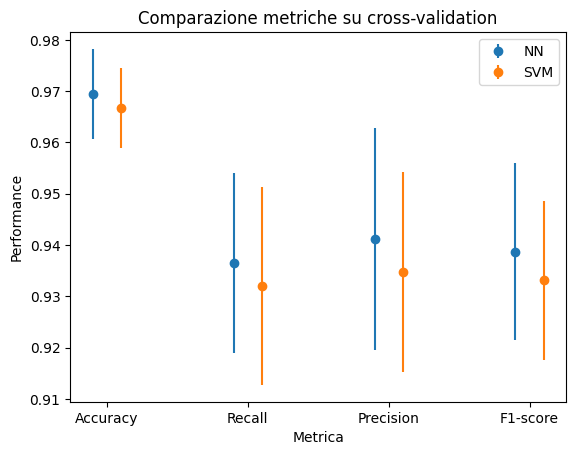

In [ ]:
metrics = ['Accuracy', "Recall", "Precision", "F1-score"]
nn_metrics_mean = []
nn_metrics_intervals = []
svm_metrics_mean = []
svm_metrics_intervals = []
confidence = 0.95

# Calculate metrics for nn
[nn_metrics_mean.append(np.mean(metric)) for metric in (accuracy_k_fold_nn, recall_k_fold_nn, precision_k_fold_nn, f1_k_fold_nn)]

# Calculate intervals for nn
[nn_metrics_intervals.append(stats.t.interval(confidence, len(metric)-1, loc=np.mean(metric), scale=stats.sem(metric))) for metric in (accuracy_k_fold_nn, recall_k_fold_nn, precision_k_fold_nn, f1_k_fold_nn)]
nn_errors = [(interval[1] - interval[0]) / 2 for interval in nn_metrics_intervals]

# Calculate metrics for svm
[svm_metrics_mean.append(np.mean(metric)) for metric in (accuracy_k_fold_svm, recall_k_fold_svm, precision_k_fold_svm, f1_k_fold_svm)]

# Calculate intervals for svm
[svm_metrics_intervals.append(stats.t.interval(confidence, len(metric)-1, loc=np.mean(metric), scale=stats.sem(metric))) for metric in (accuracy_k_fold_svm, recall_k_fold_svm, precision_k_fold_svm, f1_k_fold_svm)]
svm_errors = [(interval[1] - interval[0]) / 2 for interval in svm_metrics_intervals]

print(f"NN metrics mean: {nn_metrics_mean}")
print(f"SVM metrics mean: {svm_metrics_mean}")
print(f"NN metrics intervals: {nn_metrics_intervals}")
print(f"SVM metrics intervals: {svm_metrics_intervals}")

models = ["NN", "SVM"]
means = [nn_metrics_mean, svm_metrics_mean]
errors = [nn_errors, svm_errors]

for i, model in enumerate(models):
  x_pos = np.arange(len(metrics)) + i * 0.2  # Posizione x per ogni modello
  plt.errorbar(x_pos, means[i], yerr=errors[i], fmt='o', label=model)

plt.xticks(np.arange(len(metrics)) + 0.1, metrics)
plt.ylabel('Performance')
plt.xlabel('Metrica')
plt.title('Comparazione metriche su cross-validation')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', "Recall", "Precision", "F1-score"]
nn_test_metrics = [0.968, 0.931, 0.941, 0.936]            # Valori ottenuti sul test di riferimento
svm_test_metrics = [0.953, 0.931, 0.888, 0.909]           # Valori ottenuti sul test di riferimento

models = ["NN", "SVM"]
test_results = [nn_test_metrics, svm_test_metrics]

for i, model in enumerate(models):
    x_pos = np.arange(len(metrics)) + i * 0.2
    plt.scatter(x_pos, test_results[i], label=model)

x_pos = np.arange(len(metrics)) + 0.1
for i, x in enumerate(x_pos):
    y_values = [min(test_results[0][i], test_results[1][i]), max(test_results[0][i], test_results[1][i])]
    plt.plot([x, x], y_values, color='black', lw=1)
    plt.scatter([x, x], y_values, color='black', marker='_')
    diff = np.abs(test_results[0][i] - test_results[1][i])
    if diff > 0.01:
        plt.text(x + 0.05, (test_results[0][i] + test_results[1][i]) / 2, f'{(diff*100):.1f}%', rotation=0)

plt.xticks(np.arange(len(metrics)) + 0.1, metrics)
plt.ylabel('Performance')
plt.xlabel('Metrica')
plt.title('Comparazione metriche su test set')
plt.legend()

plt.show()

### __Complessità dei modelli__

Comparazione dei tempi di addestramento e di inferenza ottenuti con la __cross-validation__.

NN metrics mean: [20.74857542514801, 3.8066715955734254]
SVM metrics mean: [0.21148195266723632, 0.026466846466064453]
NN metrics intervals: [(16.13704449574457, 25.360106354551455), (0.6688179779081813, 6.94452521323867)]
SVM metrics intervals: [(0.19889485288855313, 0.22406905244591951), (0.0248345549946876, 0.028099137937441305)]


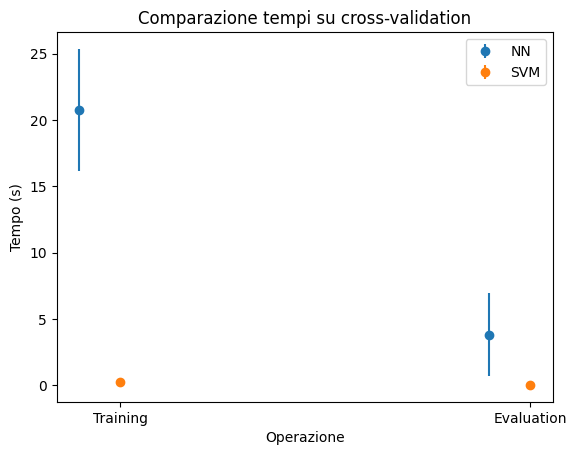

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

confidence = 0.95

operations = ['Training', 'Evaluation']
nn_times_mean = []
nn_times_intervals = []
svm_times_mean = []
svm_times_intervals = []

# Calculate times for nn
[nn_times_mean.append(np.mean(times)) for times in (training_times_nn, evaluation_times_nn)]

# Calculate intervals for nn
[nn_times_intervals.append(stats.t.interval(confidence, len(times)-1, loc=np.mean(times), scale=stats.sem(times))) for times in (training_times_nn, evaluation_times_nn)]
nn_errors = [(interval[1] - interval[0]) / 2 for interval in nn_times_intervals]

# Calculate metrics for svm
[svm_times_mean.append(np.mean(times)) for times in (timesAddestramento_svm, timesInferenza_svm)]

# Calculate intervals for svm
[svm_times_intervals.append(stats.t.interval(confidence, len(times)-1, loc=np.mean(times), scale=stats.sem(times))) for times in (timesAddestramento_svm, timesInferenza_svm)]
svm_errors = [(interval[1] - interval[0]) / 2 for interval in svm_times_intervals]

print(f"NN metrics mean: {nn_times_mean}")
print(f"SVM metrics mean: {svm_times_mean}")
print(f"NN metrics intervals: {nn_times_intervals}")
print(f"SVM metrics intervals: {svm_times_intervals}")

models = ["NN", "SVM"]
means = [nn_times_mean, svm_times_mean]
errors = [nn_errors, svm_errors]

for i, model in enumerate(models):
  x_pos = np.arange(len(operations)) + i * 0.1
  plt.errorbar(x_pos, means[i], yerr=errors[i], fmt='o', label=model)

plt.xticks(np.arange(len(operations)) + 0.1, operations)
plt.ylabel('Tempo (s)')
plt.xlabel('Operazione')
plt.title('Comparazione tempi su cross-validation')
plt.legend()

plt.show()

### Curva __ROC__

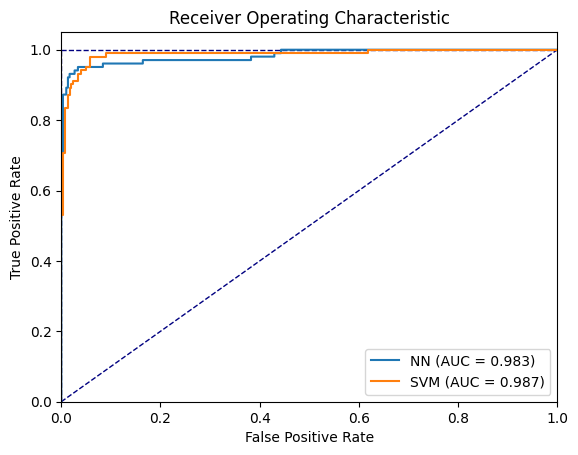

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_test_pred_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_test_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot([0, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot([0, 1], [1, 1], color='navy', lw=1, linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Plotta la curva ROC dei due modelli per comparare le performance

plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC = {roc_auc_nn:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Curva __Precision-Recall__

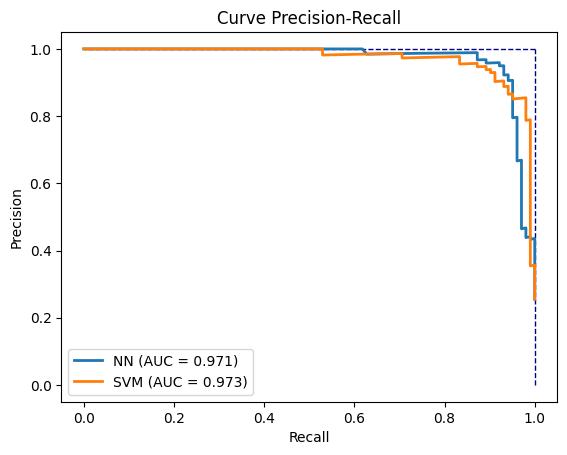

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, y_test_pred_prob_nn)
prec_rec_auc_nn = auc(recall_nn, precision_nn)

precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_test_pred_prob_svm)
prec_rec_auc_svm = auc(recall_svm, precision_svm)

plt.plot([1, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.plot([1, 0], [1, 1], color='navy', lw=1, linestyle='--')
plt.plot(recall_nn, precision_nn, lw=2, label='NN (AUC = %0.3f)' % prec_rec_auc_nn)
plt.plot(recall_svm, precision_svm, lw=2, label='SVM (AUC = %0.3f)' % prec_rec_auc_svm)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curve Precision-Recall')
plt.legend(loc="lower left")
plt.show()

In [ ]:
min_precision, delta = 0.8, 0.025
crit_precisions = [min_precision + delta * i for i in range(int((1 - min_precision) / delta) + 1)]
crit_thresholds = []

max_recalls = []

for prec in crit_precisions:
    index = np.argmax(precision_nn >= prec)
    max_recalls.append(recall_nn[index])
    crit_thresholds.append(thresholds_nn[index])

# Create a dataframe with the precision and maximum recall values
df = pd.DataFrame({'Threshold': crit_thresholds,'Precision': crit_precisions, 'Recall': max_recalls})
print("Precision vs Recall a vari livelli della soglia decisionale per il modello NN")
df

Precision vs Recall a vari livelli della soglia decisionale per il modello NN


,Threshold,Precision,Recall
0,0.004020,0.800,0.950980
1,0.010515,0.825,0.950980
2,0.013082,0.850,0.950980
3,0.039176,0.875,0.950980
4,0.121829,0.900,0.950980
5,0.497881,0.925,0.931373
6,0.929742,0.950,0.921569
7,0.996544,0.975,0.872549


In [ ]:
min_precision, delta = 0.8, 0.025
crit_precisions = [min_precision + delta * i for i in range(int((1 - min_precision) / delta) + 1)]
crit_thresholds = []

max_recalls = []

for prec in crit_precisions:
    index = np.argmax(precision_svm >= prec)
    max_recalls.append(recall_svm[index])
    crit_thresholds.append(thresholds_svm[index])

# Create a dataframe with the precision and maximum recall values
df = pd.DataFrame({'Threshold': crit_thresholds,'Precision': crit_precisions, 'Recall': max_recalls})
print("Precision vs Recall a vari livelli della soglia decisionale per il modello SVM")
df

Precision vs Recall a vari livelli della soglia decisionale per il modello SVM


,Threshold,Precision,Recall
0,0.092800,0.800,0.980392
1,0.104316,0.825,0.980392
2,0.215921,0.850,0.980392
3,0.394417,0.875,0.941176
4,0.639528,0.900,0.931373
5,0.763291,0.925,0.911765
6,0.860672,0.950,0.872549
7,0.915681,0.975,0.833333
